## SleepStudy Multilevel Models using pymc

This is a translation of the Exercise: Linear Multilevel Models. From brms to pymc

In [1]:
import pymc3 as pm
import arviz as az
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Import some custom functions
import sys
sys.path.append('./utils/')
from plotting_utils import plot_linear_regression, plot_individual_sleep_data

%matplotlib inline
#Set plotting options
sns.set_context('talk')
sns.set_style('darkgrid', {"axes.facecolor": ".9"})

#KeyWord arguments used to adjust bambi default params to brms
BRMS_ARGS = {'draws': 2000,
             'tune': 2000,
             'chains': 4,
             'target_accept': 0.95} #check if thats actually correct

In [2]:
#Get the sleepstudy data from somewhere
sleepstudy = pd.read_csv('https://www.picostat.com/system/files/datasets/dataset-85663.csv')
sleepstudy

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
...,...,...,...
175,329.6076,5,372
176,334.4818,6,372
177,343.2199,7,372
178,369.1417,8,372


In [3]:
#Start with a simple linear model
with pm.Model() as model_sleep1:
    #Define priors
    #I roughly use here what I got from bambi -> ask sarah on how to get the stuff straight from brms
    intercept = pm.Normal("Intercept", mu=300, sigma=260)
    coefficients = pm.Normal("Days", mu=0, sigma=50)
    noise = pm.HalfStudentT("noise", nu=4, sigma=50)
    #Combine with observed Data
    y_observed = pm.Normal("Reaction",
                           mu=intercept + coefficients * sleepstudy['Days'],
                           sigma=noise,
                           observed=sleepstudy['Reaction'])
    
    fit_sleep1 = pm.sample(return_inferencedata=True, **BRMS_ARGS)
    pos_pred_sleep1 = pm.sample_posterior_predictive(fit_sleep1.posterior)
    
az.concat(fit_sleep1, az.from_pymc3(posterior_predictive=pos_pred_sleep1), inplace=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [noise, Days, Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 34 seconds.


In [ ]:
#az.summary(fit_sleep1, kind='stats')

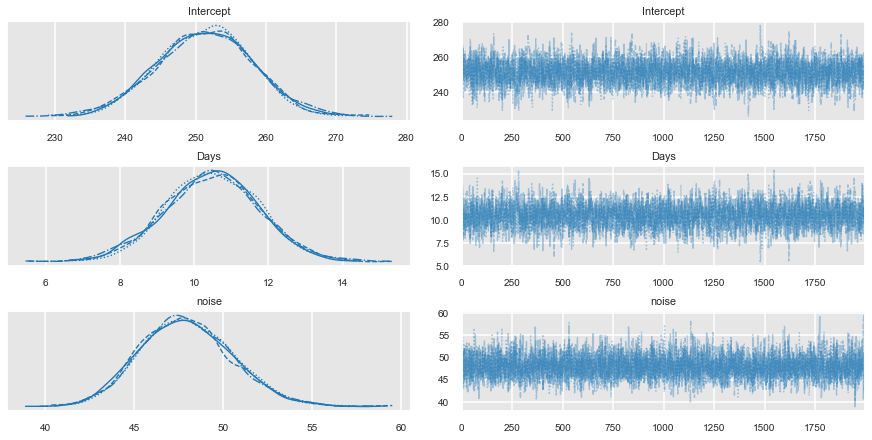

In [5]:
az.plot_trace(fit_sleep1);

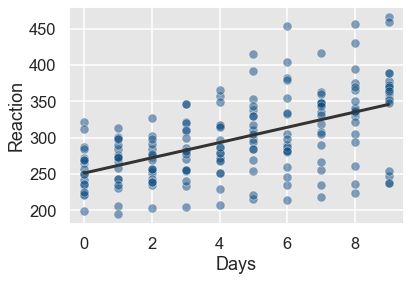

In [9]:
#Couldnt figure out how to implement bambis predict function to return 
#draws from the posterior distribution of the mean
g = plot_linear_regression(sleepstudy, fit_sleep1, 'Days', 'Reaction', add_ppm=False)

<AxesSubplot:xlabel='Reaction'>

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/core/pylabtools.py:134: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


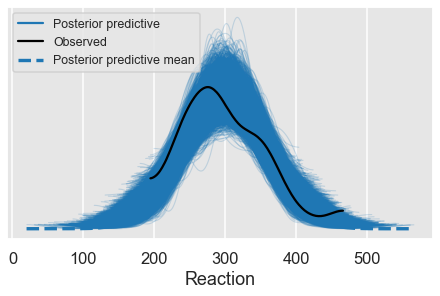

In [7]:
az.plot_ppc(fit_sleep1)

In [12]:
subject_idxs, subject = pd.factorize(sleepstudy['Subject'])
coords = {
    "subject": subject,
    "obs_id": np.arange(len(subject_idxs)),
}

In [19]:
# Now build the random intercept model
#Super unsure whether this is actually correct
with pm.Model(coords=coords) as model_sleep2:
    subject_idx = pm.Data("subject_idx", subject_idxs, dims="obs_id")
    #Define priors
    #I roughly use here what I got from bambi -> ask sarah/paul on how to get the stuff straight from brms
    
    # Hyperpriors for group effect
    mu_intercept = pm.Normal("mu_Intercept", mu=300, sigma=260)
    sigma_intercept = pm.HalfNormal('sigma_intercept', sigma= 260)
    mu_coefficients = pm.Normal("Days", mu=0, sigma=50)
    
    # individual ones for the intercept
    intercept = pm.Normal("1|Subject", mu=mu_intercept, sigma=sigma_intercept, dims="subject")

    noise = pm.HalfStudentT("noise", nu=4, sigma=50)
    #Combine with observed Data
    y_observed = pm.Normal("Reaction",
                           mu=intercept[subject_idx] + mu_coefficients * sleepstudy['Days'],
                           sigma=noise,
                           observed=sleepstudy['Reaction'],
                           dims="obs_id")
    
    fit_sleep2 = pm.sample(return_inferencedata=True, **BRMS_ARGS)
    pos_pred_sleep2 = pm.sample_posterior_predictive(fit_sleep2.posterior)
    
az.concat(fit_sleep2, az.from_pymc3(posterior_predictive=pos_pred_sleep2), inplace=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [noise, 1|Subject, Days, sigma_intercept, mu_Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 65 seconds.


0, dim: obs_id, 180 =? 180


/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [22]:
#Other than in bambi coefficients are already valid for individual subjects.
#No need to add the Intercept
summary = az.summary(fit_sleep2)

In [29]:
#Comparing the values with what bambi gives me shows that this should be correctish
#So if i want the bambi output just substract. Ask someone why this is the case
summary[summary.index.str.contains('1|Subject')] - summary.iloc[0]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
1|Subject[0],40.761,-0.318,41.832,40.777,-0.019,-0.014,2170.0,485.0,0.0
1|Subject[1],-78.252,-0.267,-78.023,-79.039,-0.013,-0.010,1271.0,492.0,0.0
1|Subject[2],-63.317,-0.070,-61.716,-62.297,-0.020,-0.015,2830.0,32.0,0.0
1|Subject[3],4.266,-0.443,5.735,3.749,-0.024,-0.017,2780.0,695.0,0.0
1|Subject[4],10.090,-0.300,11.787,9.803,-0.024,-0.017,3012.0,809.0,0.0
1|Subject[5],8.138,-0.330,8.029,7.089,-0.023,-0.017,2895.0,541.0,0.0
1|Subject[6],16.380,-0.284,17.814,16.387,-0.021,-0.015,2485.0,495.0,0.0
1|Subject[7],-3.115,-0.540,-2.343,-4.481,-0.025,-0.018,2781.0,255.0,0.0
1|Subject[8],-45.540,-0.301,-44.948,-45.698,-0.022,-0.016,2700.0,456.0,0.0
1|Subject[9],72.019,-0.132,73.358,72.647,-0.006,-0.005,546.0,-44.0,0.0


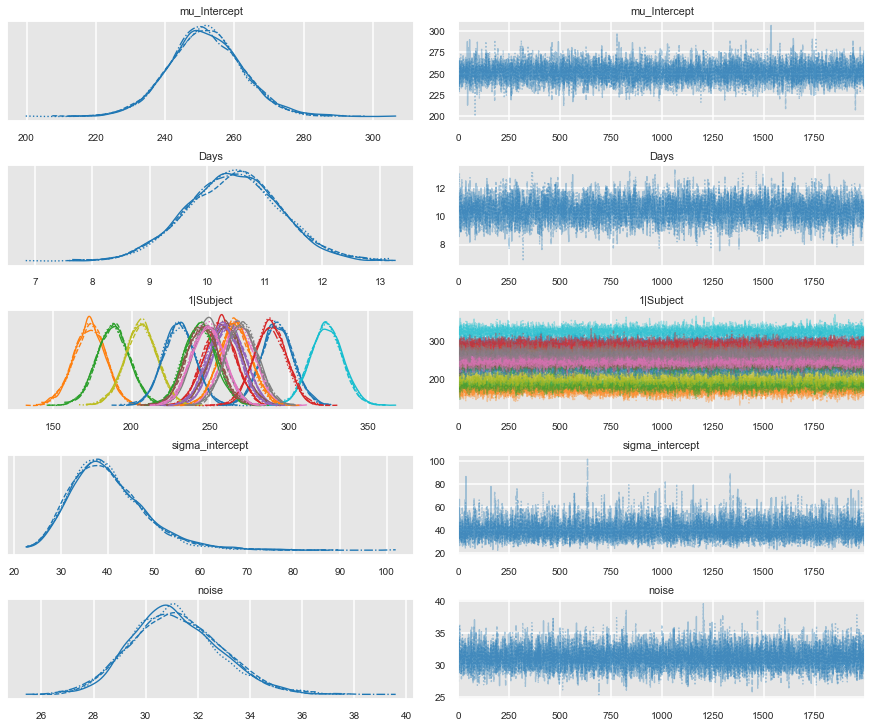

In [21]:
az.plot_trace(fit_sleep2);

In [35]:
# Now build the random intercept and random slope model
with pm.Model(coords=coords) as model_sleep3:
    subject_idx = pm.Data("subject_idx", subject_idxs, dims="obs_id")
    #Define priors
    #I roughly use here what I got from bambi -> ask sarah/paul on how to get the stuff straight from brms
    
    # Hyperpriors for group effect
    mu_intercept = pm.Normal("mu_Intercept", mu=300, sigma=260)
    sigma_intercept = pm.HalfNormal('sigma_intercept', sigma= 260)
    mu_coefficients = pm.Normal("Days", mu=0, sigma=50)
    sigma_coefficients = pm.HalfNormal('sigma_coefficients', sigma= 50)
    
    # individual ones for the intercept & slope
    intercept = pm.Normal("1|Subject", mu=mu_intercept, sigma=sigma_intercept, dims="subject")
    coefficients = pm.Normal("Days|Subject", mu=mu_coefficients, sigma=sigma_coefficients, dims="subject")

    noise = pm.HalfStudentT("noise", nu=4, sigma=50)
    #Combine with observed Data
    y_observed = pm.Normal("Reaction",
                           mu=intercept[subject_idx] + coefficients[subject_idx] * sleepstudy['Days'],
                           sigma=noise,
                           observed=sleepstudy['Reaction'],
                           dims="obs_id")
    
    fit_sleep3 = pm.sample(return_inferencedata=True, **BRMS_ARGS)
    pos_pred_sleep3 = pm.sample_posterior_predictive(fit_sleep3.posterior)
    
az.concat(fit_sleep3, az.from_pymc3(posterior_predictive=pos_pred_sleep3), inplace=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [noise, Days|Subject, 1|Subject, sigma_coefficients, Days, sigma_intercept, mu_Intercept]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 97 seconds.


0, dim: obs_id, 180 =? 180


/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


In [36]:
#Other than in bambi coefficients are already valid for individual subjects.
#No need to add the Intercept
az.summary(fit_sleep3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_Intercept,251.509,7.459,236.989,265.087,0.075,0.053,9893.0,6378.0,1.0
Days,10.459,1.719,7.329,13.834,0.017,0.012,10039.0,6116.0,1.0
1|Subject[0],252.773,12.760,229.755,277.217,0.112,0.079,13062.0,6340.0,1.0
1|Subject[1],211.039,13.706,184.627,235.989,0.138,0.098,9862.0,6625.0,1.0
1|Subject[2],212.091,13.365,185.882,236.783,0.122,0.087,11983.0,6031.0,1.0
1|Subject[3],276.251,12.960,250.864,300.103,0.118,0.084,12053.0,6075.0,1.0
1|Subject[4],274.511,12.548,251.293,298.051,0.111,0.079,12861.0,6667.0,1.0
1|Subject[5],260.664,12.601,238.353,285.064,0.112,0.079,12781.0,6065.0,1.0
1|Subject[6],268.845,12.722,246.103,293.501,0.112,0.080,13033.0,6192.0,1.0
1|Subject[7],243.857,12.407,221.325,267.304,0.098,0.069,15940.0,6163.0,1.0


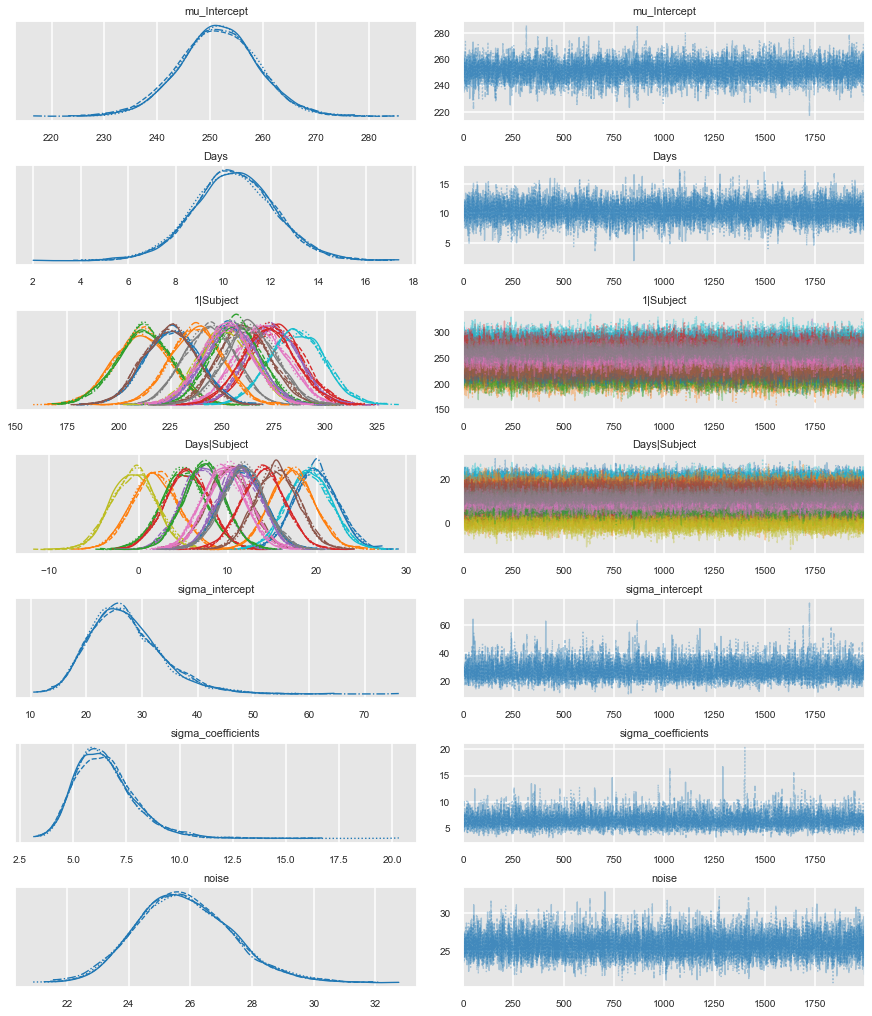

In [38]:
az.plot_trace(fit_sleep3);

<AxesSubplot:xlabel='Reaction'>

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


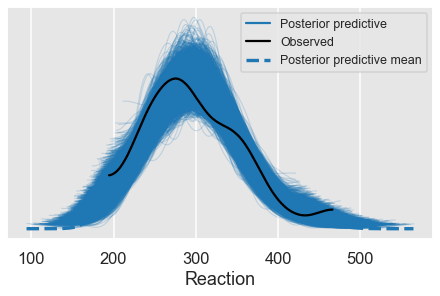

In [41]:
az.plot_ppc(fit_sleep3)

In [39]:
#Compare all trhee models:
models = {
    "fixed_intercept_fixed_slope": fit_sleep1,
    "random_intercept_fixed_slope": fit_sleep2,
    "random_intercept_random_slope": fit_sleep3,
}
df_compare = az.compare(models)
df_compare

/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/usr/local/Caskroom/miniconda/base/envs/ml/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
random_intercept_random_slope,0,-860.682151,34.298851,0.000000,9.528020e-01,22.588096,0.000000,True,log
random_intercept_fixed_slope,1,-884.784018,19.320558,24.101868,1.171235e-16,14.340937,11.970069,False,log
fixed_intercept_fixed_slope,2,-953.393860,3.297806,92.711710,4.719795e-02,10.475387,21.245079,False,log


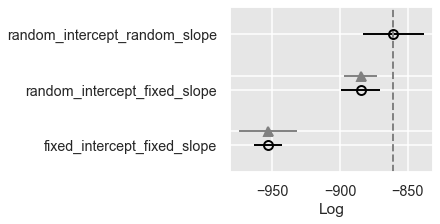

In [40]:
az.plot_compare(df_compare, insample_dev=False);